In [1]:
# Change directory to the upper directory.
import os

analysis_dir_name = "analysis"

current_dir = os.path.split(os.getcwd())[1]
if current_dir == analysis_dir_name:
    os.chdir("..")

In [2]:
import ai.nn.data_set as ds
from ai.nn.neural_network import format_data_set, get_inputs_real_outputs
from ai.nn.evaluation import errors, histogram_percentage
from ai.helpers import count_num_masked_tiles, count_num_empty_tiles_not_masked, data_set_file_path, model_file_path

%matplotlib notebook
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np
import random

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
seed = 42

subgrid_radius = 2
num_tiles_subgrids = ((subgrid_radius * 2) + 1) ** 2
num_rows_grid = 10
num_columns_grid = 10
num_bombs_grid = 10
num_no_bm_subgrids = 5000
num_bm_subgrids = 5000
# 'bm' means that the tile in the middle of the subgrids contains a bomb.
num_masked_subgrids = 10
with_flags = True

ds_no_bm_file_name = data_set_file_path(num_rows_grid, num_columns_grid, num_bombs_grid, subgrid_radius, False)
ds_bm_file_name = data_set_file_path(num_rows_grid, num_columns_grid, num_bombs_grid, subgrid_radius, True)
# 'bm' means that the tile in the middle of the subgrids contains a bomb.
model_file_name = model_file_path(num_rows_grid, num_columns_grid, num_bombs_grid, subgrid_radius, with_flags=with_flags)

random.seed(seed)

# Load the data set.
data_set_gen = ds.read_data_set(ds_no_bm_file_name)
for i in range(int(ds.SIZE / 2)): next(data_set_gen) # Skip the half of the data set.
data_set = [next(data_set_gen) for i in range(num_no_bm_subgrids)]

data_set_gen = ds.read_data_set(ds_bm_file_name)
for i in range(int(ds.SIZE / 2)): next(data_set_gen) # Skip the half of the data set.
data_set.extend([next(data_set_gen) for i in range(num_bm_subgrids)])
print("Data set loaded.")

# Format the data set.
training_set = format_data_set(data_set, num_masked_subgrids, with_flags=with_flags)
print("Data set formatted.")

# Get the 'x' and 'y_true' vectors.
x, y_true = get_inputs_real_outputs(training_set)
print("Inputs and real outputs extracted.")

# Load the model.
model = load_model(model_file_name)

# Prediction and errors.
y_pred = model.predict(x)
y_pred = [y_p[0] for y_p in y_pred]

error_func = lambda y_t, y_p: abs(y_t - y_p)
err = errors(y_true, y_pred, error_func)
print("Errors computed.")

Data set loaded.
Data set formatted.
Inputs and real outputs extracted.
Errors computed.


In [4]:
opacity = 1
color = '#FED487'
edge_color = 'black'
mean_color = 'orange'
median_color = 'red'
dot_color = 'black'

save_fig = True
plot_path = analysis_dir_name + "/plots/"
fig_format = 'png'
fig_dpi = 500

<IPython.core.display.Javascript object>


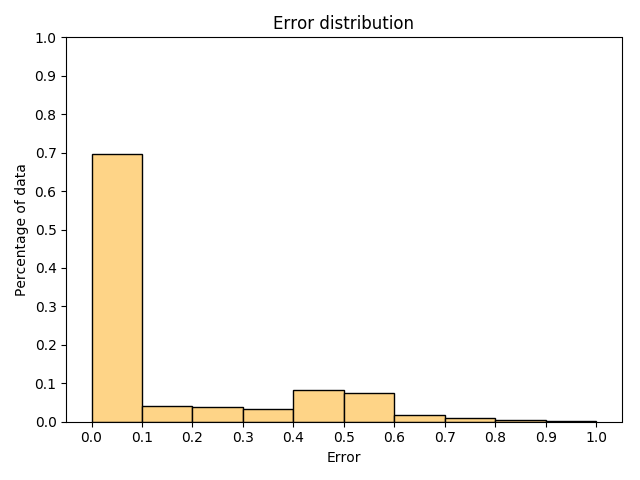

In [5]:
# Histogram percentage

perc_counts, bins = histogram_percentage(err, 10, (0.0, 1.0))

width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
fig = plt.figure()
plt.bar(center, perc_counts, align='center', width=width, color=color, edgecolor=edge_color, alpha=opacity)
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.title('Error distribution')
plt.xlabel('Error')
plt.ylabel('Percentage of data')
plt.tight_layout()
plt.show()
if save_fig:
    plt.savefig((plot_path + 'error_distribution.' + 'eps'), format='eps', dpi=fig_dpi)

<IPython.core.display.Javascript object>


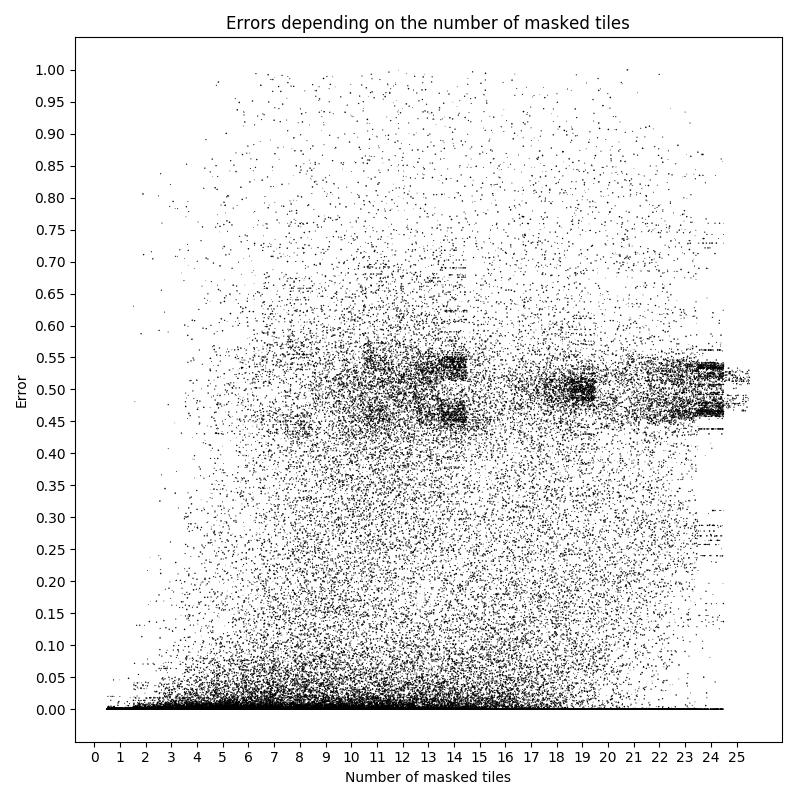

In [7]:
# Scatter plot of errors depending on the number of masked tiles

#random.seed(42)

jitter = 0.5
num_masked_tiles = []
for x_t, e_t in zip(x, err):
    masked_tiles = count_num_masked_tiles(x_t)
    masked_tiles += random.uniform(-jitter, jitter) # Add a jitter.
    num_masked_tiles.append(masked_tiles)

fig = plt.figure(figsize=(8, 8))
plt.scatter(num_masked_tiles, err, s=np.arange(0.1, 1.1, 0.1), linewidths=0.1, c=dot_color, alpha=opacity)

plt.xticks(range(num_tiles_subgrids + 1))
plt.yticks(np.arange(0.0, 1.05, 0.05))
plt.title('Errors depending on the number of masked tiles')
plt.xlabel('Number of masked tiles')
plt.ylabel('Error')
plt.tight_layout()
plt.show()
if save_fig:
    plt.savefig((plot_path + 'errors_depending_on_num_masked_tiles.' + fig_format), format=fig_format, dpi=fig_dpi)

<IPython.core.display.Javascript object>


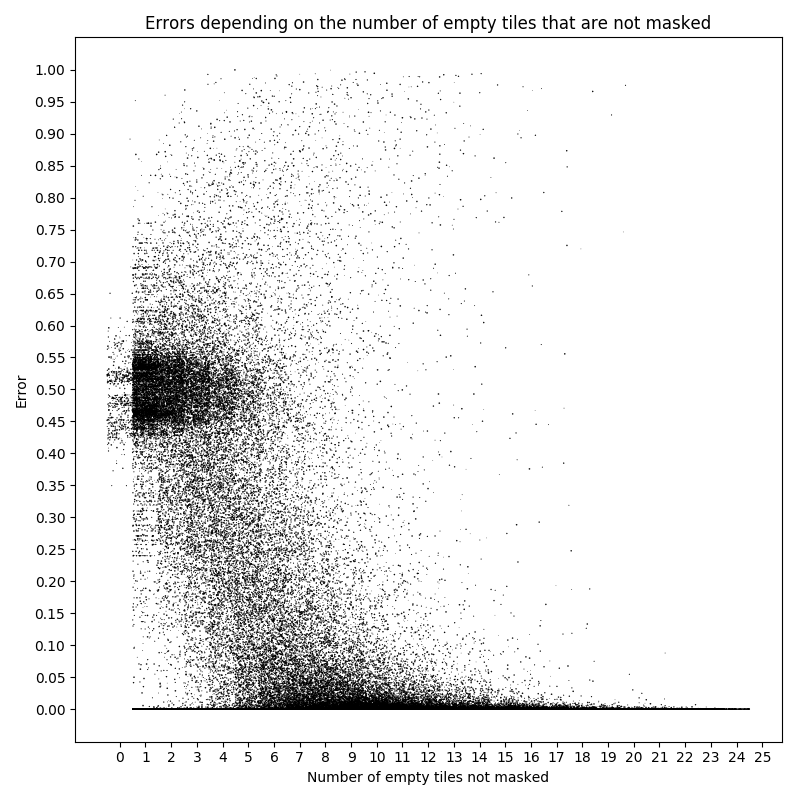

In [6]:
# Scatter plot of errors depending on the number of empty tiles that are not masked.

#random.seed(42)

jitter = 0.5
num_masked_tiles = []
for x_t, e_t in zip(x, err):
    empty_tiles_not_masked = count_num_empty_tiles_not_masked(x_t)
    empty_tiles_not_masked += random.uniform(-jitter, jitter) # Add a jitter.
    num_masked_tiles.append(empty_tiles_not_masked)

fig = plt.figure(figsize=(8, 8))
plt.scatter(num_masked_tiles, err, s=np.arange(0.1, 1.1, 0.1), linewidths=0.1, c=dot_color, alpha=opacity)

plt.xticks(range(num_tiles_subgrids + 1))
plt.yticks(np.arange(0.0, 1.05, 0.05))
plt.title('Errors depending on the number of empty tiles that are not masked')
plt.xlabel('Number of empty tiles not masked')
plt.ylabel('Error')
plt.tight_layout()
plt.show()
if save_fig:
    plt.savefig((plot_path + 'errors_depending_on_num_empty_tiles_not_masked.' + fig_format), format=fig_format, dpi=fig_dpi)